## Part 1: Summary Statistics and Data Visualization

---
---

## 0. Importing Relevant Libraries and Data Cleaning

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew, kurtosis

dirname = 'Top 100 Crypto Coins/'

# Load the list of cryptocurrencies
CryptoCoins = pd.read_csv(os.path.join(dirname, 'Current Crypto leaderboard.csv'))

# Function to convert short-form strings to numeric values
def convert_shortform_to_numeric(s):
    """
    Convert a string with financial shortforms (e.g., '1.5M', '2B', '3K', '4.7%') to a numeric value.

    Parameters:
    s (str, int, float): The input value to be converted. It can be a string containing a number with 
                         financial shortforms, an integer, or a float.

    Returns:
    float: The numeric value after conversion. If the input is already an integer or float, it is returned as is.
           If the input is a string, it is converted to a float based on the shortform suffix.
           If the input is a percentage string, it is converted to a float without the percentage sign.
           If the input cannot be converted, returns numpy.nan.
    """
    if isinstance(s, (int, float)):
        return s
    if isinstance(s, str):
        s = s.replace('$', '').replace(',', '').strip()
        multiplier = 1
        if s.endswith('B'):
            multiplier = 1e9
            s = s[:-1]
        elif s.endswith('M'):
            multiplier = 1e6
            s = s[:-1]
        elif s.endswith('K'):
            multiplier = 1e3
            s = s[:-1]
        elif s.endswith('%'):
            s = s[:-1]
            try:
                return float(s)
            except ValueError:
                return np.nan
        try:
            return float(s) * multiplier
        except ValueError:
            return np.nan
    else:
        return np.nan

# Columns to convert
cols_to_convert = ['Market Cap', 'Vol (24H)', 'Total Vol', 'Chg (24H)', 'Chg (7D)']
for col in cols_to_convert:
    CryptoCoins[col] = CryptoCoins[col].apply(convert_shortform_to_numeric)
    if col in ['Chg (7D)', 'Chg (24H)', 'Total Vol']:
        CryptoCoins.rename(columns={col: col + '%' }, inplace=True)

## 1. Summary Statistics

---

In [ ]:
# Generate summary statistics for all coins
summary_stats = []

for index, row in CryptoCoins.iterrows():
    crypto_name = row['Name']
    symbol = row['Symbol']
    csv_file = os.path.join(dirname, f'{crypto_name}.csv')
    
    # Check if the CSV file exists
    if os.path.isfile(csv_file):
        # Load the historical data
        data = pd.read_csv(csv_file, parse_dates=['Date'])
        data.sort_values('Date', inplace=True)
        data.reset_index(drop=True, inplace=True)
        
        # Compute log returns
        data['log_price'] = np.log(data['Close'])
        data['log_return'] = data['log_price'].diff()
        
        # Drop missing values
        data = data.dropna(subset=['log_return'])
        
        if not data.empty:
            # Calculate statistics
            mean_return = data['log_return'].mean() * 100  # Convert to percentage
            std_return = data['log_return'].std() * 100  # Convert to percentage
            skewness = skew(data['log_return'])
            kurt = kurtosis(data['log_return'], fisher=True)  # Fisher's definition (subtract 3)
            min_return = data['log_return'].min() * 100
            max_return = data['log_return'].max() * 100
            start_date = data['Date'].iloc[0]
            end_date = data['Date'].iloc[-1]
            
            # Append to the list
            summary_stats.append({
                'Name': crypto_name,
                'Symbol': symbol,
                'Mean Return (%)': mean_return,
                'StdDev (%)': std_return,
                'Skewness': skewness,
                'Excess Kurtosis': kurt,
                'Min Return (%)': min_return,
                'Max Return (%)': max_return,
                'Start Date': start_date,
                'End Date': end_date
            })
    else:
        print(f"Data file for {crypto_name} not found.")

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary_stats)

# Save the summary statistics to a CSV file
summary_df.to_csv(os.path.join(dirname, 'Crypto_Summary_Statistics.csv'), index=False)

# Display the first few rows
print("Summary Statistics:")
print(summary_df.head())

/home/vscode/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vscode/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/vscode/.local/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1158: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


Data file for BitTorrent not found.
Data file for Terra Classic not found.
Summary Statistics:
       Name Symbol  Mean Return (%)  StdDev (%)  Skewness    Kurtosis  \
0   Bitcoin    BTC         0.277653    6.444674  2.601067   88.152640   
1  Ethereum    ETH         0.209093    5.639623 -0.577770    8.110400   
2    Tether   USDT         0.000514    0.462685  0.043481   31.666761   
3  USD Coin   USDC        -0.000191    0.944639 -8.515186  277.269819   
4       BNB    BNB         0.286543    6.013164  0.381693   14.276406   

   Min Return (%)  Max Return (%) Start Date   End Date  
0      -84.882867      147.417980 2010-07-19 2022-08-23  
1      -58.963852       25.859945 2016-03-11 2022-08-23  
2       -5.746963        4.528996 2017-04-15 2022-08-23  
3      -22.808380       12.463144 2018-12-07 2022-08-23  
4      -54.308390       52.921787 2017-11-10 2022-08-23  


/home/vscode/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vscode/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vscode/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


## 2. Visualizations

### 2.1. Market Capitalization (Pie Chart)
---

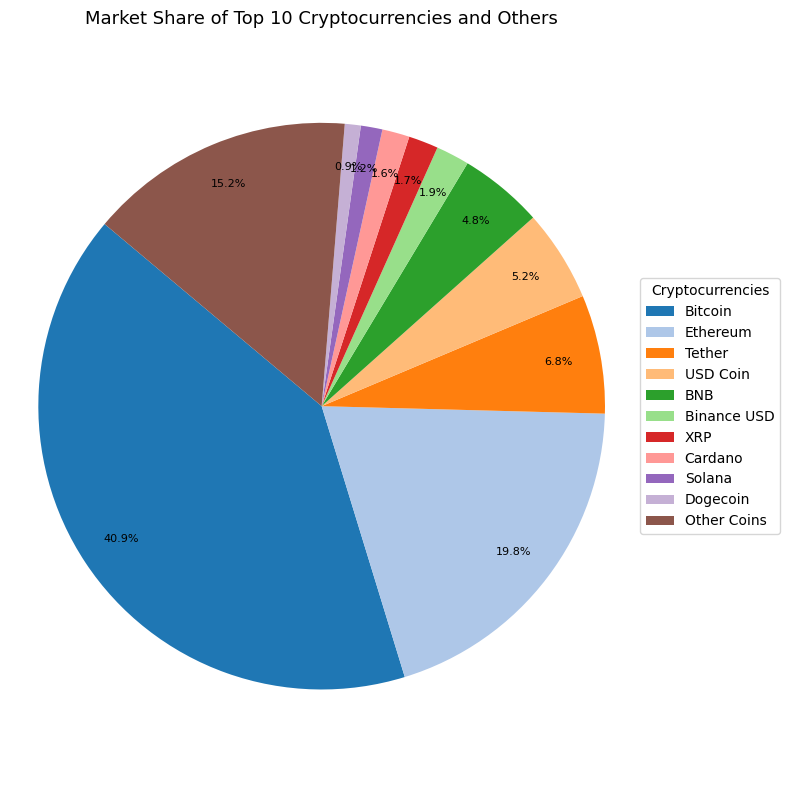

In [3]:
# Visualize Cryptocurrencies by Market Cap using an improved pie chart
CryptoCoins['Market Cap'] = pd.to_numeric(CryptoCoins['Market Cap'], errors='coerce')

# Remove cryptocurrencies with missing market cap
CryptoCoins = CryptoCoins.dropna(subset=['Market Cap'])

# Sort the cryptocurrencies by market cap in descending order
CryptoCoins = CryptoCoins.sort_values('Market Cap', ascending=False)

# Select the top N cryptocurrencies
top_n = 10  # You can change this value as needed
top_cryptos = CryptoCoins.head(top_n)
other_cryptos = CryptoCoins.iloc[top_n:]

# Calculate total market cap of other coins
other_market_cap = other_cryptos['Market Cap'].sum()

# Prepare data for pie chart
labels = top_cryptos['Name'].tolist() + ['Other Coins']
sizes = top_cryptos['Market Cap'].tolist() + [other_market_cap]

# Define a color palette
colors = sns.color_palette('tab20', n_colors=top_n + 1)

# Create the pie chart with improved aesthetics
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes,labels=None, colors=colors,autopct='%1.1f%%',startangle=140,pctdistance=0.85)

# Add a legend
plt.legend(wedges,labels,title='Cryptocurrencies',loc='center left',bbox_to_anchor=(1, 0.5)
)

# Adjust text properties to prevent overlapping
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_size(8)

plt.title(f'Market Share of Top {top_n} Cryptocurrencies and Others', fontsize=13)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

### 2.2. Short-Term (7D) and Medium-Term (30D) Log-Returns Correlations

Choose k, the number of cryptocurrencies for analysis in decreasing order of Market Cap

---

/tmp/ipykernel_4821/2481027045.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_30d.dropna(inplace=True)
/tmp/ipykernel_4821/2481027045.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_7d.dropna(inplace=True)


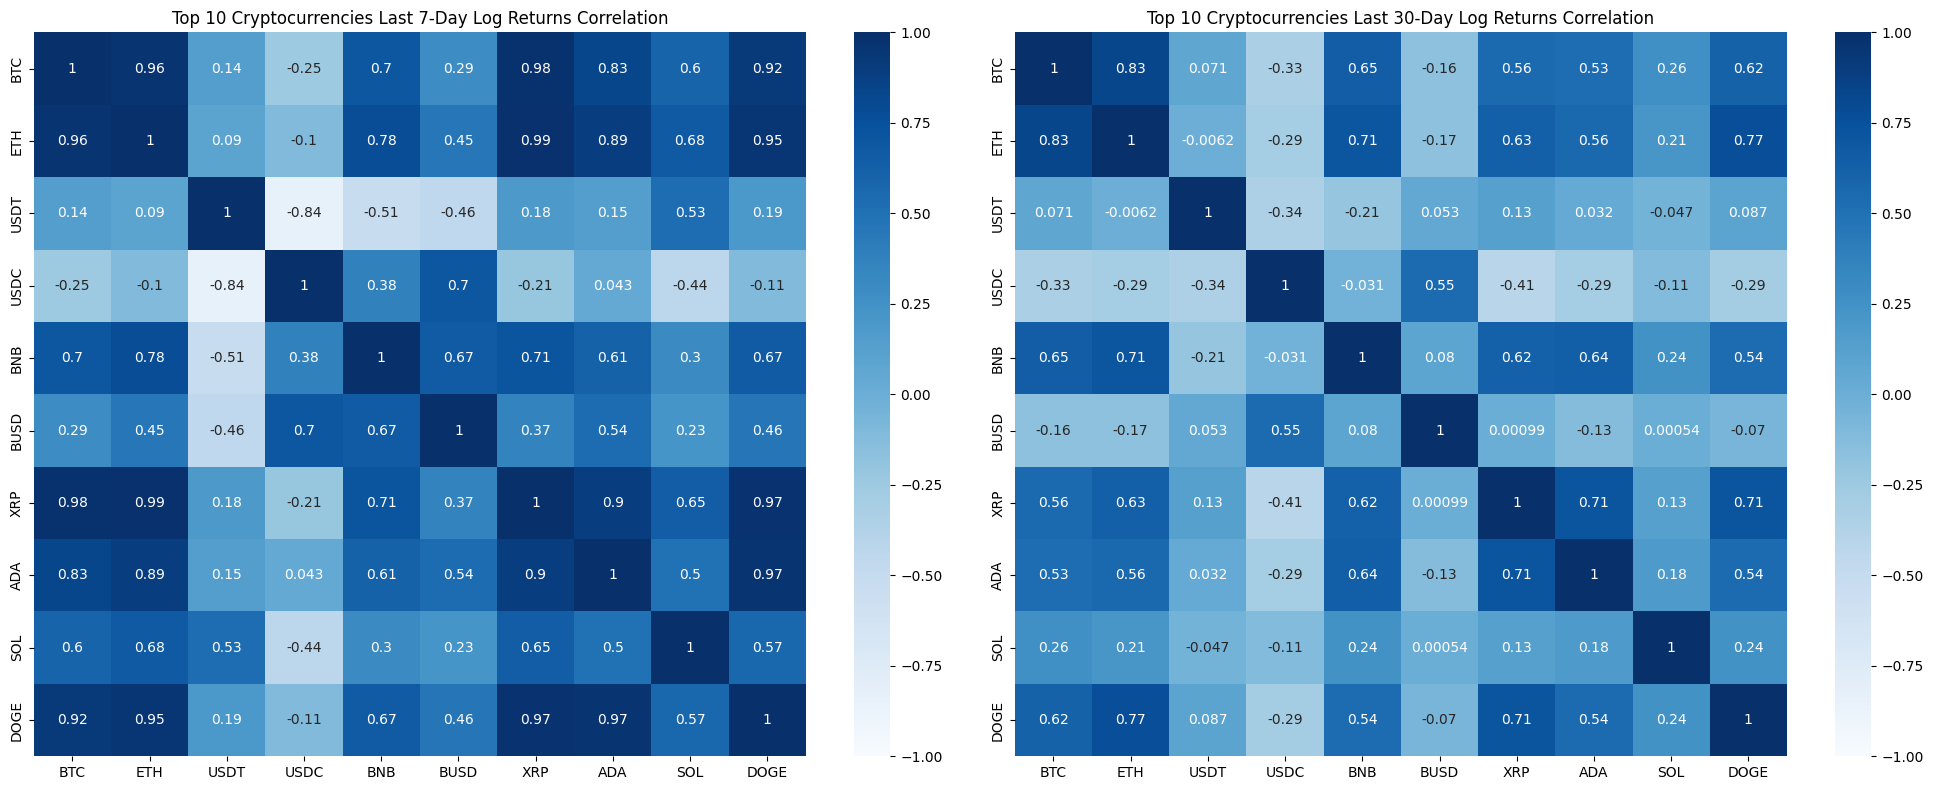

In [4]:
# Visualize Top k Cryptocurrencies' Short-Term (7D) and Medium-Term (30D) Log-Returns Correlation
k = 10

# Select the top k cryptocurrencies
top_k_cryptos = CryptoCoins.head(k)

# Initialize a dictionary to store log returns
log_returns = {}

# Load historical data and compute log returns for each cryptocurrency
for index, row in top_k_cryptos.iterrows():
    crypto_name = row['Name']
    symbol = row['Symbol']
    csv_file = os.path.join(dirname, f'{crypto_name}.csv')
    
    if os.path.isfile(csv_file):
        # Load the historical data
        data = pd.read_csv(csv_file, parse_dates=['Date'])
        data.sort_values('Date', inplace=True)
        data.reset_index(drop=True, inplace=True)
        
        # Compute log returns
        data['log_price'] = np.log(data['Close'])
        data['log_return'] = data['log_price'].diff()
        
        # Drop missing values
        data = data.dropna(subset=['log_return'])
        
        # Store the log returns with the cryptocurrency symbol as the key
        log_returns[symbol] = data[['Date', 'log_return']]
    else:
        print(f"Data file for {crypto_name} not found.")

# Corrected code for data alignment and merging
# Merge the log returns on the 'Date' column to ensure alignment
returns_df = None

for symbol, df in log_returns.items():
    df = df.set_index('Date')
    df = df[['log_return']]
    df = df.rename(columns={'log_return': symbol})
    if returns_df is None:
        returns_df = df
    else:
        returns_df = returns_df.join(df, how='inner')  # Use inner join to keep common dates

# Check if returns_df is empty
if returns_df is None or returns_df.empty:
    print("No common dates found among the selected cryptocurrencies.")
else:
    # Get the last 30 days and 7 days of data
    returns_30d = returns_df.tail(30)
    returns_7d = returns_df.tail(7)
    
    # Drop rows with NaN values (if any)
    returns_30d.dropna(inplace=True)
    returns_7d.dropna(inplace=True)
    
    # Ensure there is enough data to calculate correlations
    if len(returns_7d) < 2 or len(returns_30d) < 2:
        print("Not enough data to calculate correlations.")
    else:
        # Calculate the correlation matrices
        corr_matrix_7d = returns_7d.corr()
        corr_matrix_30d = returns_30d.corr()
        
        # Plot the heatmaps
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Heatmap for 7-day correlation
        sns.heatmap(corr_matrix_7d, ax=axes[0], annot=True, cmap='Blues', vmin=-1, vmax=1)
        axes[0].set_title(f'Top {k} Cryptocurrencies Last 7-Day Log Returns Correlation')
        
        # Heatmap for 30-day correlation
        sns.heatmap(corr_matrix_30d, ax=axes[1], annot=True, cmap='Blues', vmin=-1, vmax=1)
        axes[1].set_title(f'Top {k} Cryptocurrencies Last 30-Day Log Returns Correlation')
        
        plt.tight_layout()
        plt.show()

### 2.3. Bar Chart of Top N Cryptocurrencies by Trading Volume

Choose N, the number of cryptocurrencies in decreasing order of 24H Trading Volume

---

/tmp/ipykernel_4821/2666967106.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_n_volume, x='Name', y='Vol (24H)', palette='Spectral')


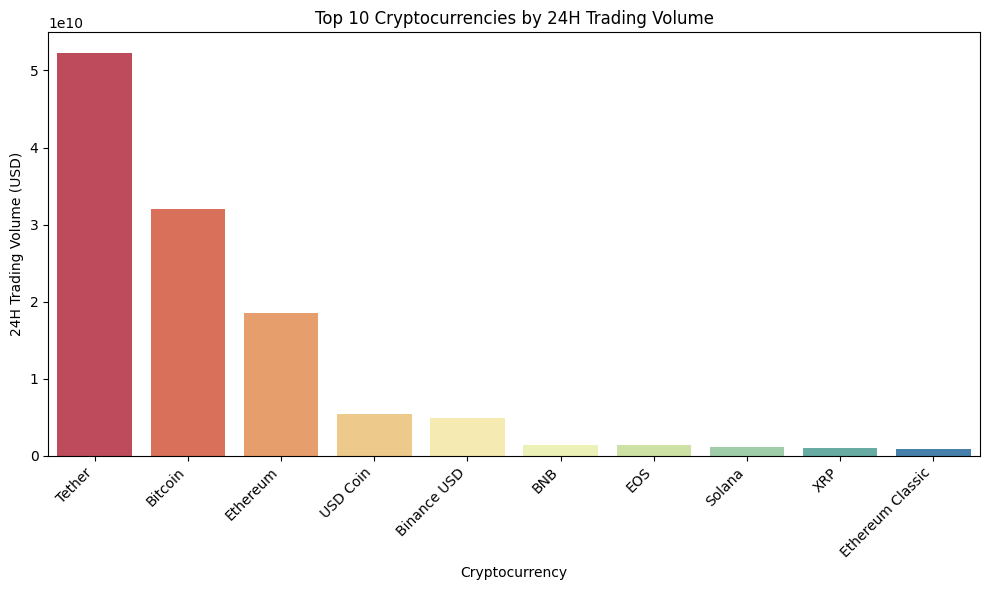

In [5]:
# Select top N cryptocurrencies by trading volume
N = 10
top_n_volume = CryptoCoins.sort_values('Vol (24H)', ascending=False).head(N)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top_n_volume, x='Name', y='Vol (24H)', palette='Spectral')
plt.title('Top 10 Cryptocurrencies by 24H Trading Volume')
plt.xlabel('Cryptocurrency')
plt.ylabel('24H Trading Volume (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()